In [80]:
%run ../startup.py

INFO:root:/cloud/syncthing/git/combinators appended to python path
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:root:%load_ext autoreload
INFO:root:%autoreload 2
INFO:root:from IPython.core.debugger import set_trace
INFO:root:from IPython.core.display import display, HTML
INFO:root:import torch
INFO:root:import numpy as np
INFO:root:import scipy as sp
INFO:root:import matplotlib
INFO:root:import matplotlib.pyplot as plt
INFO:root:%matplotlib inline
INFO:root:import seaborn as sns
INFO:root:import pandas as pd


<Figure size 1152x648 with 0 Axes>

In [81]:
import torch
from combinators.densities import GMM
import combinators.trace.utils as trace_utils
import combinators.tensor.utils as tensor_utils
import math

degrees = lambda angle: [math.cos(angle), math.sin(angle)]
locs=torch.tensor([degrees(a*math.pi/180) for a in [0, 45, 90, 135, 180, 225, 270, 315]]) * 10
program = GMM(locs=locs, covs=[torch.eye(2) for _ in range(len(locs))], name="gmm")
tr, xs8 = program.sample(sample_shape=(1000,))

for k, rv in tr.items():
    print('{:>11}: {}'.format(k, tensor_utils.show(rv.value)))

print()

print(xs8[:10])

        gmm: float32[1000×2]# Qm1Mjnv3wOM=

tensor([[ -0.2131, -10.2467],
        [  8.3755,   6.9632],
        [  9.5361,  -5.1501],
        [ -7.4963,   6.1203],
        [ -9.5019,   1.1881],
        [  9.6319,   0.0860],
        [  9.9475,  -0.3183],
        [-10.5273,   0.1079],
        [-10.1450,  -0.1125],
        [  7.8784,  -7.4966]])


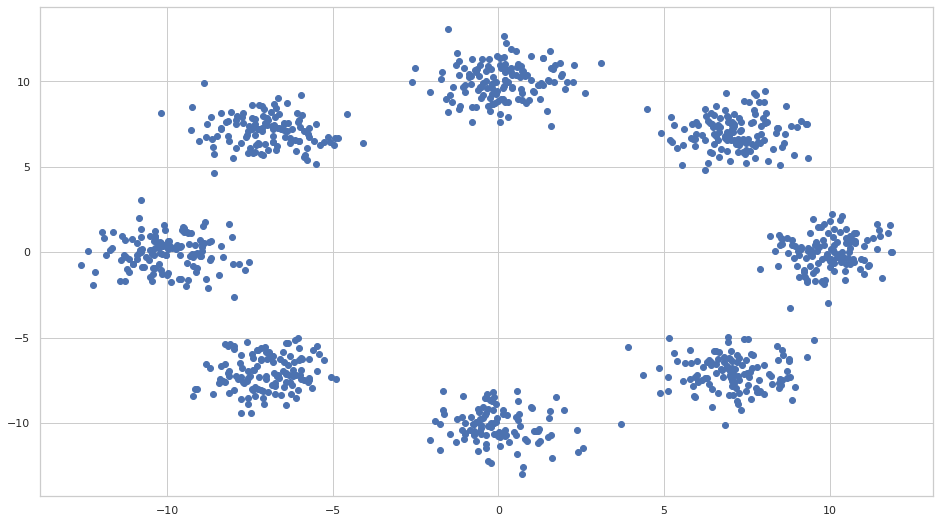

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from matplotlib import colors
from scipy.interpolate import interpn
from matplotlib import cm

c='C0'
cm_endpoints = [(0., (*colors.to_rgb(c), 0.)),
                (1., (*colors.to_rgb(c), 1.))]
lin_alpha = colors.LinearSegmentedColormap.from_list('incr_alpha', cm_endpoints)

fig, ax = plt.subplots()
ax.scatter(xs8[:,0], xs8[:,1], cmap=lin_alpha)
plt.show()

In [83]:
from combinators.densities import RingGMM
import visualize
ring_gmm = RingGMM(loc_scale=20, scale=0.5, count=13)

tr13, xs13 = ring_gmm.sample(sample_shape=(10000,))


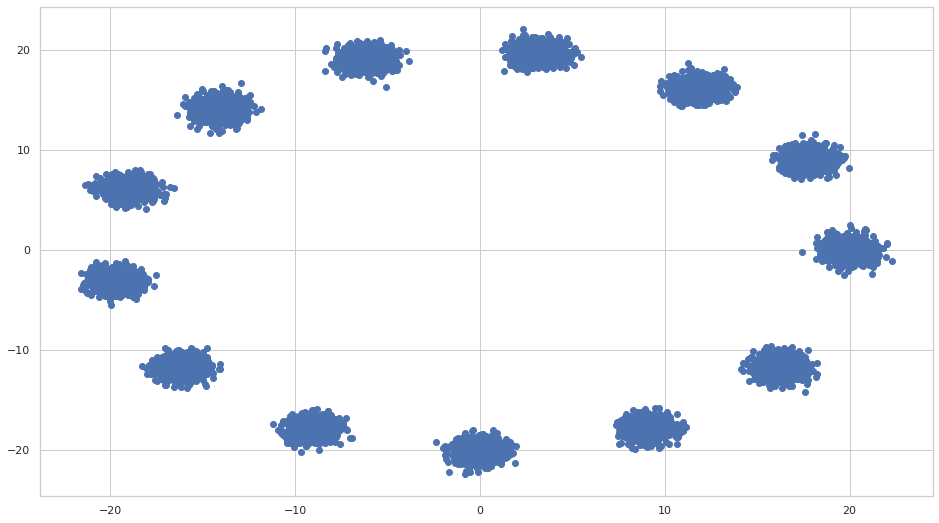

In [84]:
import matplotlib.gridspec as gridspec

_ = visualize.scatter(xs13)

<AxesSubplot:>

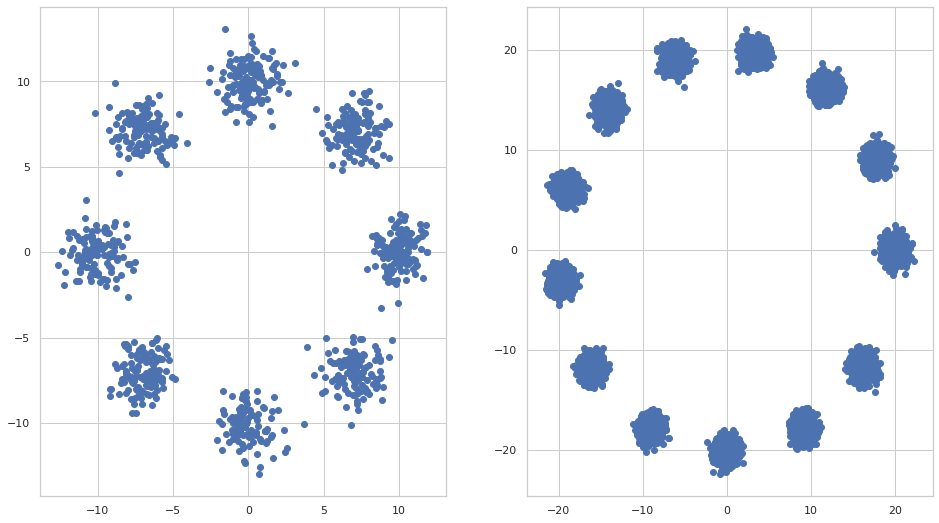

In [85]:
fig = plt.figure()
gspec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gspec[0, 0])
visualize.scatter(xs8, ax=ax0)
ax1 = fig.add_subplot(gspec[0, 1])

visualize.scatter(xs13, ax=ax1)


In [86]:
ring_gmm = RingGMM(scale=8, count=8)

tr, xs = ring_gmm.sample(sample_shape=(2000,))
print(tr)
print(xs.shape, tr[ring_gmm.name].log_prob.shape)
#visualize.scatter(xs, c='C2', lws=tr['RingGMM'].log_prob.unsqueeze(1))
lws = tr[ring_gmm.name].log_prob.unsqueeze(0)



Trace{'RingGMM': ImproperRandomVariable(float32[2000×2]# J67lRvuvItY=)}
torch.Size([2000, 2]) torch.Size([2000])


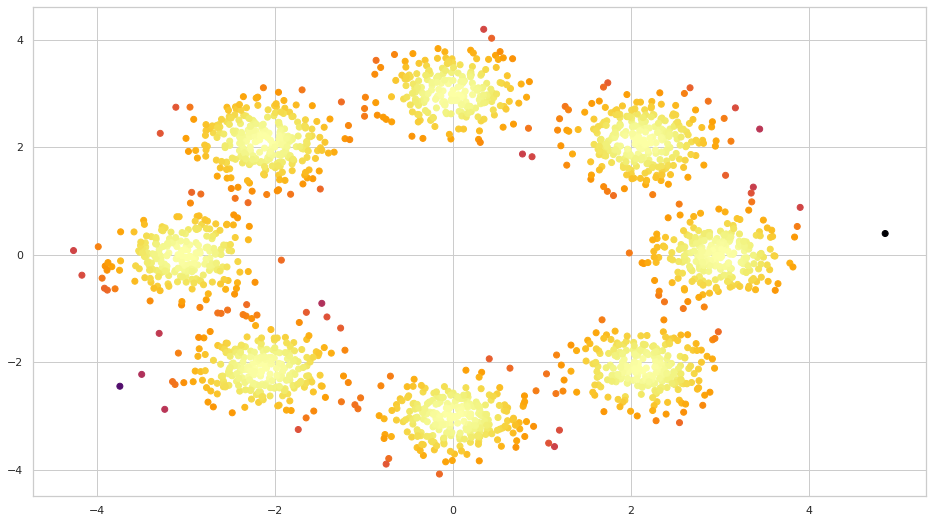

In [87]:

import visualize as V
from torch import distributions as D
import matplotlib.pyplot as plt

ring_gmm = RingGMM(loc_scale=3, scale=0.16, count=8)

tr, xs = ring_gmm.sample(sample_shape=(2000,))
xs = xs.cpu()


plt.scatter(xs[:,0], xs[:,1], c=tr[ring_gmm.name].log_prob.squeeze().cpu(), cmap='inferno')


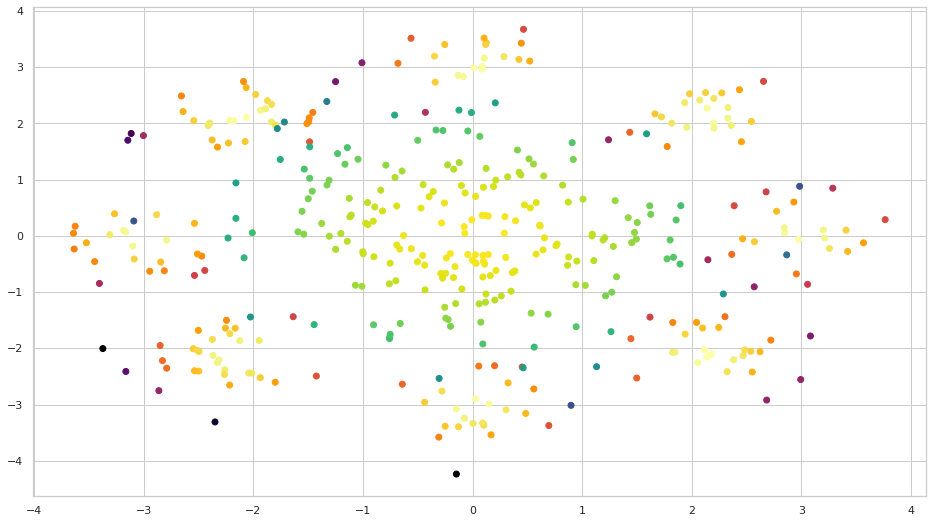

In [88]:
import visualize as V
from torch import distributions as D
import matplotlib.pyplot as plt

ring_gmm = RingGMM(loc_scale=3, scale=0.16, count=8)

tr, xs = ring_gmm.sample(sample_shape=(200,))
xs = xs.cpu()


plt.scatter(xs[:,0], xs[:,1], c=tr[ring_gmm.name].log_prob.squeeze().cpu(), cmap='inferno')
mn = D.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2)*1)
xs = mn.sample((200,))
plt.scatter(xs[:,0], xs[:,1], c=mn.log_prob(xs), cmap='viridis')


In [89]:
ring_gmm = RingGMM(loc_scale=3, scale=0.16, count=8)
from combinators.densities import MultivariateNormal
mvn = MultivariateNormal(name='x', loc=torch.zeros(2), cov=torch.eye(2))

tr, x = mvn(sample_shape=(256,))

# tr, xs = ring_gmm(sample_shape=(200,))
# xs = xs.cpu()


# plt.scatter(xs[:,0], xs[:,1], c=tr[ring_gmm.name].log_prob.squeeze().cpu(), cmap='inferno')
# mn = D.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2)*1)
# xs = mn.sample((200,))
# plt.scatter(xs[:,0], xs[:,1], c=mn.log_prob(xs), cmap='viridis')

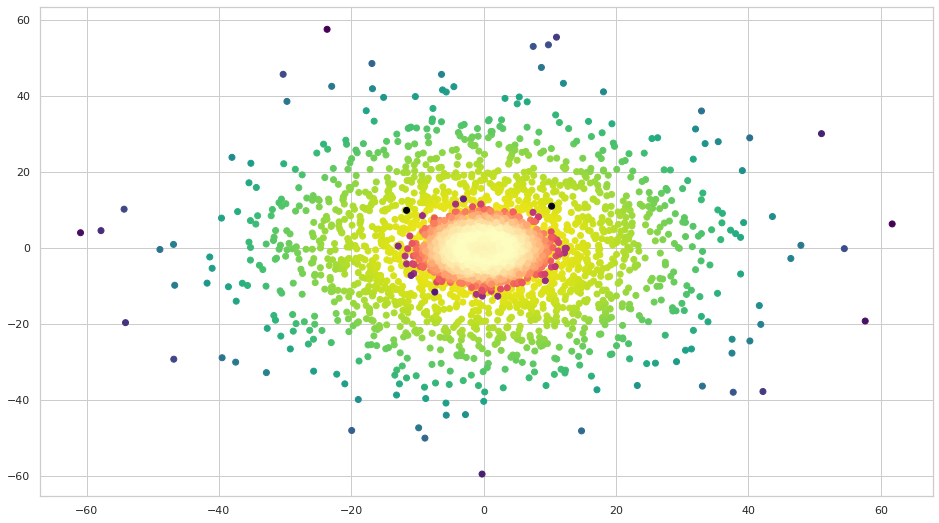

In [90]:
from combinators.densities import MultivariateNormal
def mk_mvn(i, loc, std=1):
    return MultivariateNormal(name=f'g{i}', loc=torch.ones(2)*loc, cov=torch.eye(2)*std**2, device="cpu")

num_targets = 4
proposal_std = 8
g0 = mk_mvn(0, 0, std=16)
gK = RingGMM(scale=8, count=8, name=f"g{num_targets - 1}").to('cpu')
tr, o = g0(sample_shape=(2000,))
plt.scatter(tr[g0.name].value[:,0], tr[g0.name].value[:,1], c=tr[g0.name].log_prob, cmap='viridis')
tr, o = gK.sample(sample_shape=(2000,))

plt.scatter(tr[gK.name].value[:,0].cpu(), tr[gK.name].value[:,1].cpu(), c=tr[gK.name].log_prob.cpu(), cmap='magma')

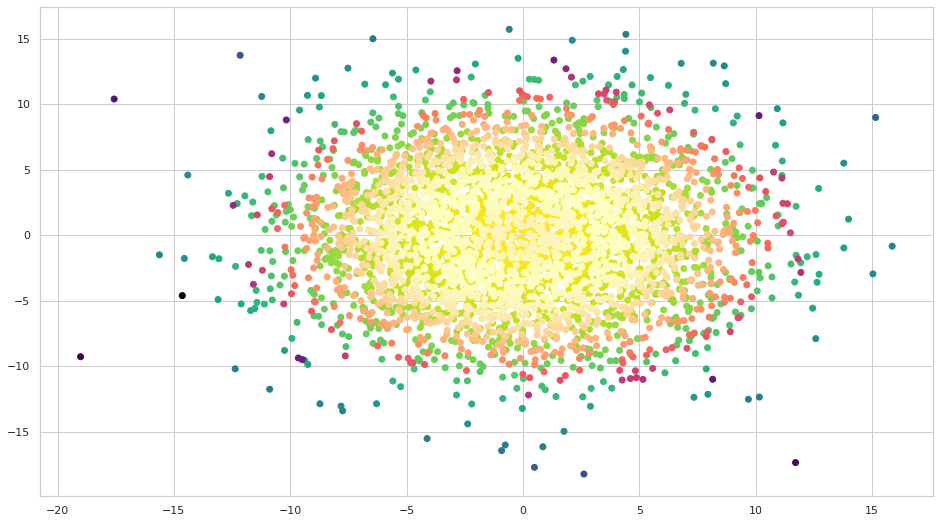

In [91]:
from combinators.densities import MultivariateNormal
def mk_mvn(i, loc, std=1):
    return MultivariateNormal(name=f'g{i}', loc=torch.ones(2)*loc, cov=torch.eye(2)*std**2, device="cpu")

num_targets = 4
proposal_std = 8
g0 = mk_mvn(0, 0, std=5)
gK = RingGMM(scale=8, count=8, name=f"g{num_targets - 1}").to('cpu')
tr, o = g0(sample_shape=(2000,))
plt.scatter(tr[g0.name].value[:,0], tr[g0.name].value[:,1], c=tr[g0.name].log_prob, cmap='viridis')
tr, o = gK.sample(sample_shape=(2000,))

plt.scatter(tr[gK.name].value[:,0].cpu(), tr[gK.name].value[:,1].cpu(), c=tr[gK.name].log_prob.cpu(), cmap='magma')

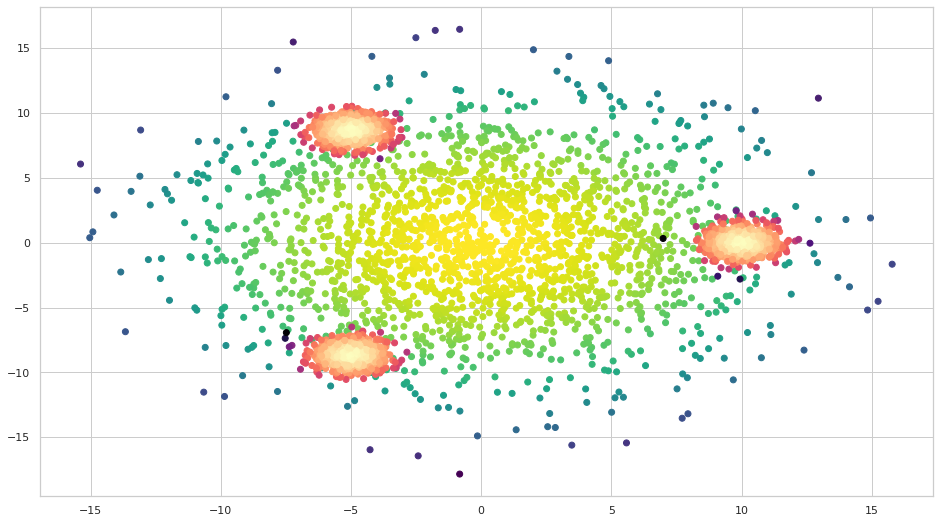

In [118]:
g0 = mk_mvn(0, 0, std=5)
tr, o = g0(sample_shape=(2000,))
plt.scatter(tr[g0.name].value[:,0], tr[g0.name].value[:,1], c=tr[g0.name].log_prob, cmap='viridis')


gK = RingGMM(loc_scale=10, scale=0.5, count=3, name=f"g{num_targets - 1}").to('cpu')
tr, o = gK.sample(sample_shape=(2000,))
plt.scatter(tr[gK.name].value[:,0].cpu(), tr[gK.name].value[:,1].cpu(), c=tr[gK.name].log_prob.cpu(), cmap='magma')

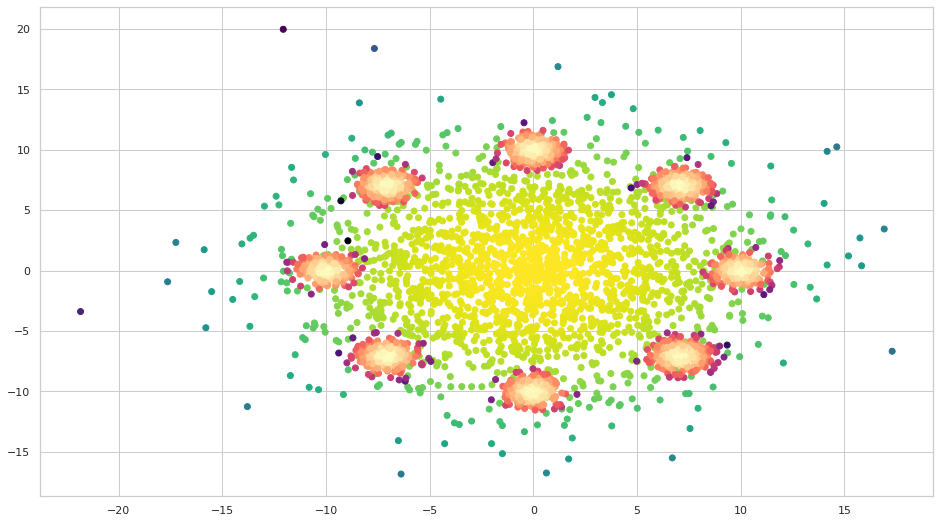

In [114]:
g0 = mk_mvn(0, 0, std=5)
tr, o = g0(sample_shape=(2000,))
plt.scatter(tr[g0.name].value[:,0], tr[g0.name].value[:,1], c=tr[g0.name].log_prob, cmap='viridis')

gK = RingGMM(loc_scale=10, scale=0.5, count=8, name=f"g{num_targets - 1}").to('cpu')
tr, o = gK.sample(sample_shape=(2000,))
plt.scatter(tr[gK.name].value[:,0].cpu(), tr[gK.name].value[:,1].cpu(), c=tr[gK.name].log_prob.cpu(), cmap='magma')